## <font color=purple>Import needed modules</font>

In [1]:
!pip install tensorflow -q     
!pip install -q -U keras-tuner 

In [2]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#TensorFlow requirements
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

#scikit learn imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

## <font color=purple>Function Definitions

In [3]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file, sourcePath, compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [4]:
#function provided that plots the learning curve for neural networks
def nn_plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()

## <font color=purple>Source Data

In [5]:
#download data files if not currently downloaded into the current working directory
path = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename = "sephora_website_dataset.csv"


path2 = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename2 = "product_info.csv"


downloadDataResource(filename, path)
downloadDataResource(filename2, path2)

Data resource sephora_website_dataset.csv already downloaded.
Data resource product_info.csv already downloaded.


In [6]:
#create a dataframe with the data from the CSV file
df = pd.read_csv(filename)
df2 = pd.read_csv(filename2)

## <font color=purple>Source Data

In [7]:
#download data files if not currently downloaded into the current working directory
path = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename = "sephora_website_dataset.csv"


path2 = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename2 = "product_info.csv"


downloadDataResource(filename, path)
downloadDataResource(filename2, path2)

Data resource sephora_website_dataset.csv already downloaded.
Data resource product_info.csv already downloaded.


In [8]:
#create a dataframe with the data from the CSV file
df = pd.read_csv(filename)
df2 = pd.read_csv(filename2)

## <font color=purple>Transform Data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168 entries, 0 to 9167
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9168 non-null   int64  
 1   brand                   9168 non-null   object 
 2   category                9168 non-null   object 
 3   name                    9168 non-null   object 
 4   size                    9168 non-null   object 
 5   rating                  9168 non-null   float64
 6   number_of_reviews       9168 non-null   int64  
 7   love                    9168 non-null   int64  
 8   price                   9168 non-null   float64
 9   value_price             9168 non-null   float64
 10  URL                     9168 non-null   object 
 11  MarketingFlags          9168 non-null   bool   
 12  MarketingFlags_content  9168 non-null   object 
 13  options                 9168 non-null   object 
 14  details                 9168 non-null   

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [11]:
df2.rename(columns = {'product_name':'name'}, inplace = True)
#df2.rename(columns = {'rating':'2023ratings'}, inplace = True)

In [12]:
df = pd.merge(df,df2[['name',"secondary_category"]],on='name', how='left')

In [13]:
df.name.str.split().explode().value_counts().head(10)

Mini     665
&        629
Cream    530
Set      464
Lip      404
Mask     402
de       400
Eau      400
Brush    393
Oil      387
Name: name, dtype: int64

In [14]:
df["mini"] = [1 if "Mini" in x else 0 for x in df["name"]]
df["cream"] = [1 if "Cream" in x else 0 for x in df["name"]]
df["set"] = [1 if "Set" in x else 0 for x in df["name"]]
df["mask"] = [1 if "Mask" in x else 0 for x in df["name"]]
df["eau"] = [1 if "Eau" in x else 0 for x in df["name"]]
df["lip"] = [1 if "Lip" in x else 0 for x in df["name"]]
df["brush"] = [1 if "Brush" in x else 0 for x in df["name"]]
df["oil"] = [1 if "Oil" in x else 0 for x in df["name"]]

In [15]:
df.ingredients.str.split().explode().value_counts().head(20)

Extract-         17337
the              17179
that             14600
of               14080
and              13214
Oil-             12294
Sodium           11416
(Ci              11147
-                10386
to               10238
Glycol-           7869
Acid-             7759
Seed              7295
or                7005
are               6973
is                6933
methacrylate-     6591
Ci                5710
be                5522
products          5429
Name: ingredients, dtype: int64

In [16]:
df["extract"] = [1 if "Extract-" in x else 0 for x in df["ingredients"]]
df["oil"] = [1 if "Oil- " in x else 0 for x in df["ingredients"]]
df["sodium"] = [1 if "Sodium" in x else 0 for x in df["ingredients"]]
df["glycol"] = [1 if "Glycol-" in x else 0 for x in df["ingredients"]]
df["acid"] = [1 if "Acid-" in x else 0 for x in df["ingredients"]]
df["seed"] = [1 if "Seed" in x else 0 for x in df["ingredients"]]
df["metha"] = [1 if "methacrylate- " in x else 0 for x in df["ingredients"]]

In [17]:
toPredict = df.loc[(df['name'] == 'Green Clean Makeup Removing Cleansing Balm') 
                   | (df['name'] == 'Glowscreen Sunscreen SPF 40')
                  | (df['name'] == 'Wisteria & Lavender Cologne')]

In [18]:
df = df[df.name != 'Green Clean Makeup Removing Cleansing Balm']
df = df[df.name != 'Glowscreen Sunscreen SPF 40']
df = df[df.name != 'Wisteria & Lavender Cologne']

In [19]:
df = df.drop(columns = ["id","name","size","category","secondary_category","brand","value_price","URL","MarketingFlags","MarketingFlags_content","options","details","how_to_use","ingredients"])

In [20]:
toPredict=toPredict.drop(columns=["id","name","size","category","secondary_category","brand","value_price","URL","MarketingFlags","MarketingFlags_content","options","details","how_to_use","ingredients"])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9229 entries, 0 to 9231
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating              9229 non-null   float64
 1   number_of_reviews   9229 non-null   int64  
 2   love                9229 non-null   int64  
 3   price               9229 non-null   float64
 4   online_only         9229 non-null   int64  
 5   exclusive           9229 non-null   int64  
 6   limited_edition     9229 non-null   int64  
 7   limited_time_offer  9229 non-null   int64  
 8   mini                9229 non-null   int64  
 9   cream               9229 non-null   int64  
 10  set                 9229 non-null   int64  
 11  mask                9229 non-null   int64  
 12  eau                 9229 non-null   int64  
 13  lip                 9229 non-null   int64  
 14  brush               9229 non-null   int64  
 15  oil                 9229 non-null   int64  
 16  extrac

In [22]:
df.head()

,rating,number_of_reviews,love,price,online_only,exclusive,limited_edition,limited_time_offer,mini,cream,...,eau,lip,brush,oil,extract,sodium,glycol,acid,seed,metha
0,4.0,4,3002,66.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.5,76,2700,66.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.5,26,2600,180.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,23,2900,120.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.5,2,943,72.0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## <font color=purple>Neural Network - Regression

### Split data set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['price']), 
    df.price, 
    test_size=.2, 
    random_state=32
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7383, 21), (7383,), (1846, 21), (1846,))

### Prepare Data

In [24]:
cat_attribs = []#["category","secondary_category"]

#set the numerical attributes
num_attribs = list( X_train.drop(cat_attribs,axis=1) )

num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), #because no missing values, not used
 ('std_scaler', StandardScaler()),   
])

#define the column transformation process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse = False), cat_attribs)      #because no categorical attributes, not used 
])

In [25]:
#diagram pipeline process (NOTE this only works because of the import and set statement at the top)
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['rating', 'number_of_reviews', 'love',
                                  'online_only', 'exclusive', 'limited_edition',
                                  'limited_time_offer', 'mini', 'cream', 'set',
                                  'mask', 'eau', 'lip', 'brush', 'oil',
                                  'extract', 'sodium', 'glycol', 'acid', 'seed',
                                  'metha']),
                                ('cat', OneHotEncoder(sparse=False), [])])

In [26]:
full_pipeline.fit(df)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['rating', 'number_of_reviews', 'love',
                                  'online_only', 'exclusive', 'limited_edition',
                                  'limited_time_offer', 'mini', 'cream', 'set',
                                  'mask', 'eau', 'lip', 'brush', 'oil',
                                  'extract', 'sodium', 'glycol', 'acid', 'seed',
                                  'metha']),
                                ('cat', OneHotEncoder(sparse=False), [])])

### Prepare the data

In [27]:
#create an array of prepared data based on the training data set and the Pipeline process defined above
X_train = full_pipeline.fit_transform( X_train)
X_test = full_pipeline.transform(X_test )

X_train.shape, X_test.shape

((7383, 21), (1846, 21))

In [28]:
#scale the Y data
yscaler = MinMaxScaler()
y_train = yscaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test = yscaler.transform(np.array(y_test).reshape(-1,1))

### Create a Baseline Prediction

In [29]:
#predcition is based on last observed value
baseline_prediction = yscaler.inverse_transform( y_test.mean().reshape(-1,1)) 

#populate an array with the baseline prediction value
predictions = np.full(shape=y_test.shape[0], fill_value = baseline_prediction)

#unscale predicted values
actual= yscaler.inverse_transform( y_test )

#calculate the root mean square error between the prediction and the actual
naive = mean_squared_error(predictions, actual, squared=False)
print( 'Naive ERROR: ${:,.0f}'.format(naive) )

Naive ERROR: $52


### Build the Neural Network, Compile & Train

In [30]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [31]:
#the same steps above can be built and saved in a single command with the same results 
model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation="relu"),
    keras.layers.Dense(4, activation="relu"),
    keras.layers.Dense(1)
])

In [32]:
#After model is created, it needs to be compiled - this requires setting
#the loss function to mean_squared_error
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(learning_rate=.01),
              metrics=["RootMeanSquaredError"]
             )

In [33]:
#fit the model and capture the details of the fit to a variable called history
#note that validation data is dynamically allocated at 20% of the training data
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=3)
history = model.fit(X_train, 
                    y_train, 
                    epochs=500, 
                    validation_split=.2,
                    callbacks=[early_stopping]
                   )

Epoch 1/500
185/185 [==============================] - 2s 5ms/step - loss: 0.0724 - root_mean_squared_error: 0.2691 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705
Epoch 2/500
185/185 [==============================] - 1s 3ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1381
Epoch 3/500
185/185 [==============================] - 0s 3ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1257
Epoch 4/500
185/185 [==============================] - 0s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 5/500
185/185 [==============================] - 0s 2ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 6/500
185/185 [==============================] - 0s 3ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0126 

### Evaluate Performance

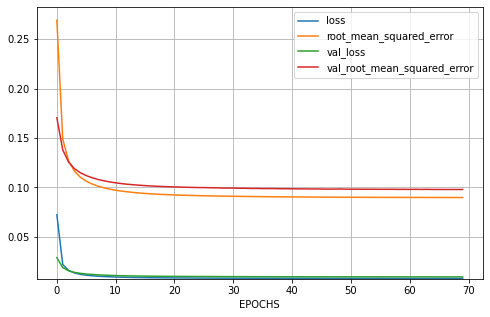

In [34]:
#plot the loss learning curve
nn_plot_learning_curve(history)

In [35]:
#evaluate model loss metric on the training set
mse, rmse = model.evaluate(X_train, y_train)
print( "Training RMSE: {:,.4f}".format(rmse) )

231/231 [==============================] - 0s 2ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915
Training RMSE: 0.0915


In [36]:
#evaluate model loss metric on the Test set
mse, rmse = model.evaluate(X_test, y_test)
print( "Test RMSE: {:,.4f}".format(rmse) )

58/58 [==============================] - 0s 2ms/step - loss: 0.0106 - root_mean_squared_error: 0.1032
Test RMSE: 0.1032


In [37]:
#predict the Training data set based on SCALED values
y_pred = model.predict(X_train)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_train)

#calculate the Root Mean Squared Error using the scaled values
rmse = mean_squared_error(pred,actual,squared=False)
print('RMSE: ${:,.2f}'.format( rmse ) )

231/231 [==============================] - 1s 2ms/step
RMSE: $45.49


In [38]:
#predict the test data set based on SCALED values
y_pred = model.predict(X_test)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_test)

#calculate the Root Mean Squared Error using the scaled values
rmse = mean_squared_error(pred,actual,squared=False)
print('RMSE: ${:,.2f}'.format( rmse ) )

58/58 [==============================] - 0s 1ms/step
RMSE: $51.29


In [39]:
#print the first 5 test cases
for x in range(5):
    print( "Actual ${:10,.0f} --- Prediction ${:10,.0f}".format( float(actual[x]), float(pred[x]) ) )

Actual $        14 --- Prediction $        48
Actual $        54 --- Prediction $        48
Actual $        44 --- Prediction $        48
Actual $        28 --- Prediction $        48
Actual $        40 --- Prediction $        48


## <font color=purple>Hyperparameter Tuning - Regression Model

In [40]:
#reset Keras backend
keras.backend.clear_session()

#set the random seed value for this example
np.random.seed(42)
tf.random.set_seed(42)

### Define Regression Model & Design Options (layers & hyperparameters)

In [41]:
def reg_model_builder(hp):
    
    #select an optimizer and learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[.01,.001,.0001])
    optimizer = hp.Choice("optimizer", values=["adam","sgd"]) 
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    #choose the number of neurons (i.e. the number of units)
    hp_units = hp.Int('units', min_value=16, max_value=256, step=12)
    
    #choose the number of layers
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=4, default=2)
        
    #build the model
    model = keras.Sequential()
    
    #first layer
    model.add(keras.layers.Flatten())

    #hidden layers
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(units=hp_units, activation='relu'))

    #last layer
    model.add(keras.layers.Dense(1))

    #compile the model
    model.compile(optimizer=optimizer,
                  loss="mean_squared_error", 
                  metrics=["RootMeanSquaredError"])
  
    return model

### Create a Hyperband Tuning Object

In [42]:
tuner = kt.Hyperband(reg_model_builder,
                     objective='val_loss',
                     max_epochs=20,                   #increase for more trials (but will take longer)
                     overwrite=True,                  #change to False and model will continue to learn from previous runs
                     hyperband_iterations=2,
                     seed=42,
                     project_name="Games_Regression"  #a local directory with this name will be created (houses log files)
                     )


In [43]:
# Search for the best performing models
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=3)
tuner.search(X_train, y_train, 
             epochs=500, 
             validation_split=0.2, 
             callbacks=[early_stopping]
             )

Trial 60 Complete [00h 00m 07s]
val_loss: 0.009717666544020176

Best val_loss So Far: 0.007506956811994314
Total elapsed time: 00h 04m 07s
INFO:tensorflow:Oracle triggered exit


In [44]:
# Get the optimal hyperparameters
best_params=tuner.get_best_hyperparameters(num_trials=1)[0]
best_params.values

{'learning_rate': 0.001,
 'optimizer': 'adam',
 'units': 244,
 'n_hidden': 3,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [45]:
#build the best model based on these parameters
best_model = reg_model_builder(best_params)


In [46]:
#fit the data to the best model & its parameters
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=3)
history=best_model.fit(X_train, y_train, 
             epochs=500, 
             validation_split=0.2, 
             callbacks=[early_stopping]
             )

Epoch 1/500
185/185 [==============================] - 1s 2ms/step - loss: 0.0315 - root_mean_squared_error: 0.1775 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 2/500
185/185 [==============================] - 0s 2ms/step - loss: 0.0312 - root_mean_squared_error: 0.1766 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917
Epoch 3/500
185/185 [==============================] - 0s 2ms/step - loss: 0.0105 - root_mean_squared_error: 0.1027 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 4/500
185/185 [==============================] - 0s 2ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881
Epoch 5/500
185/185 [==============================] - 0s 2ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 6/500
185/185 [==============================] - 0s 2ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0078 

In [47]:
#review the model 
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 21)                0         
                                                                 
 dense_4 (Dense)             (None, 244)               5368      
                                                                 
 dense_5 (Dense)             (None, 244)               59780     
                                                                 
 dense_6 (Dense)             (None, 244)               59780     
                                                                 
 dense_7 (Dense)             (None, 1)                 245       
                                                                 
Total params: 125,173
Trainable params: 125,173
Non-trainable params: 0
_________________________________________________________________


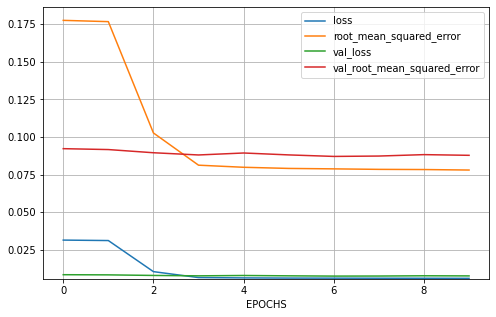

In [48]:
#plot the model's learning curve
nn_plot_learning_curve(history)

### Evaluate the Optimal Model

In [49]:
#evaluate Training Data
mse, rmse = best_model.evaluate(X_train, y_train)
print( "Training RMSE: {:,.4f}".format(rmse) )

231/231 [==============================] - 0s 1ms/step - loss: 0.0061 - root_mean_squared_error: 0.0782
Training RMSE: 0.0782


In [50]:
#evaluate Test Data
mse, rmse = best_model.evaluate(X_test, y_test)
print( "Test RMSE: {:,.4f}".format(rmse) )

58/58 [==============================] - 0s 1ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975
Test RMSE: 0.0975


In [51]:
#predict the Training data set based on SCALED values
y_pred = best_model.predict(X_train)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_train)

#calculate the Root Mean Squared Error using the scaled values
rmse = mean_squared_error(pred,actual,squared=False)
print('Training RMSE: ${:,.2f}'.format( rmse ) )

231/231 [==============================] - 0s 890us/step
Training RMSE: $38.89


In [52]:
#predict the test data set based on SCALED values
y_pred = best_model.predict(X_test)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_test)

#calculate the Root Mean Squared Error using the scaled values
rmse = mean_squared_error(pred,actual,squared=False)
print('Test RMSE: ${:,.2f}'.format( rmse ) )

58/58 [==============================] - 0s 932us/step
Test RMSE: $48.43


In [53]:
#print using format
for x in range(5):
    print( "Actual ${:10,.0f} --- Prediction ${:10,.0f}".format( float(actual[x]), float(pred[x]) ) )

Actual $        14 --- Prediction $        24
Actual $        54 --- Prediction $        50
Actual $        44 --- Prediction $        49
Actual $        28 --- Prediction $        57
Actual $        40 --- Prediction $        52


# Predictions

In [56]:
X_prepared=full_pipeline.transform(toPredict)
pred=best_model.predict(X_prepared)
pred = yscaler.inverse_transform(pred )
pred

1/1 [==============================] - 0s 20ms/step


array([[39.651253],
       [37.742413],
       [42.727856]], dtype=float32)